In [14]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import glob
import warnings
import matplotlib
import nc_time_axis
import cftime
from datetime import datetime
from cmip6_preprocessing.preprocessing import combined_preprocessing

xr.set_options(display_style='html')
plt.rcParams['figure.figsize'] = 5,2.5

import xskillscore as xs
import seaborn as sns
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
from xgcm import Grid

import matplotlib.ticker as tick
from matplotlib.pyplot import cm
from scipy.signal import find_peaks

In [15]:
# we use this in our scatter plots

def textonly(ax, txt, fontsize = 14, loc = 2, *args, **kwargs):
    at = AnchoredText(txt,
                      prop=dict(size=fontsize), 
                      frameon=True,
                      loc=loc)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.1")
    ax.add_artist(at)
    return at

def corr_model(arr1, arr2):
    models = np.intersect1d(arr1.model.values,arr2.model.values)
    corr_co = xs.pearson_r(arr1.sel(model = models),arr2.sel(model = models),dim='model',skipna=True )
    corr_p = xs.pearson_r_p_value(arr1.sel(model = models),arr2.sel(model = models),dim='model',skipna=True )
    return corr_co, corr_p, models


### Define grid variables

In [16]:
file_dx = '/gws/nopw/j04/ukfafmip/users/enewsom/regrid_from_jonathan_thetoa/cmip5/dx_regrid.nc'
dx =  xr.open_dataset(file_dx).assign_attrs(source_id='model')
dx=combined_preprocessing(dx)
dx = dx['dx']

file_da = '/gws/nopw/j04/ukfafmip/users/enewsom/regrid_from_jonathan_thetoa/cmip5/area_regrid.nc'
da =  xr.open_dataset(file_da).assign_attrs(source_id='model')
da=combined_preprocessing(da)
area = da['cell_area']
dy= area/dx



### Open SST and OHU data and define lists of models

In [17]:

SST_change_cmip5 =  xr.open_dataarray('SST_change_cmip5.nc').rename('sst_anom')
SST_change_cmip6 =  xr.open_dataarray('SST_change_cmip6.nc').rename('sst_anom')
OHU_change_cmip5 =  xr.open_dataarray('OHU_change_cmip5.nc').rename('ohu_anom')
OHU_change_cmip6 =  xr.open_dataarray('OHU_change_cmip6.nc').rename('ohu_anom')

SST_change = xr.concat([SST_change_cmip5,SST_change_cmip6],dim='model')
OHU_change = xr.concat([OHU_change_cmip5,OHU_change_cmip6],dim='model')

models_cmip5=SST_change_cmip5.model
models_cmip6=SST_change_cmip6.model

#### Calculate OHUE for list of regions (global, mid-lat, N high lat, S high lat, Low lat)

In [18]:
ocean_mask=(SST_change/SST_change).isel(model=0)
delta_SST= (SST_change*area).sum(['x','y'])/((ocean_mask*area).sum(['x','y']))

shl_lats = slice(-90,-60)
nhl_lats = slice(60,90)
ll_lats = slice(-30,30)
ml_lats = slice(-60,60)

OHU_change_gl = (OHU_change*area).sum(['x','y']).assign_coords(surf_reg='global') 
OHUA  = (OHU_change*area)
OHU_change_ml = OHUA.sel(y=ml_lats).where(np.abs(OHUA.y)>30).sum(['x','y']).assign_coords(surf_reg='mid_lats')

OHU_change_shl = (OHU_change*area).sel(y=shl_lats).sum(['x','y']).assign_coords(surf_reg='so_highlats') 
OHU_change_nhl= (OHU_change*area).sel(y=nhl_lats).sum(['x','y']).assign_coords(surf_reg='nh_highlats') 
OHU_change_ll = (OHU_change*area).sel(y=ll_lats).sum(['x','y']).assign_coords(surf_reg='low_lats') 

delta_OHU= xr.concat([OHU_change_gl,OHU_change_ml,OHU_change_nhl,OHU_change_shl,OHU_change_ll],dim='surf_reg')
OHUE = delta_OHU/delta_SST/area.sum(['x','y']).rename('ohue')


### MIT DATA

In [19]:
OHUE_kgm_g =  xr.open_dataarray('OHUE_kgm_MITgcm.nc').rename('ohue').assign_coords(surf_reg='global') 
OHUE_H_g =  xr.open_dataarray('OHUE_H_MITgcm.nc').rename('ohue').assign_coords(surf_reg='global') 
OHUE_kv_g =  xr.open_dataarray('OHUE_kv_MITgcm.nc').rename('ohue').assign_coords(surf_reg='global') 

OHUE_kgm_ml =  xr.open_dataarray('OHUE_mid_kgm_MITgcm.nc').rename('ohue').assign_coords(surf_reg='mid_lats') 
OHUE_H_ml =  xr.open_dataarray('OHUE_mid_H_MITgcm.nc').rename('ohue').assign_coords(surf_reg='mid_lats') 
OHUE_kv_ml =  xr.open_dataarray('OHUE_mid_kv_MITgcm.nc').rename('ohue').assign_coords(surf_reg='mid_lats') 

OHUE_kv = xr.concat([OHUE_kv_g,OHUE_kv_ml],dim='surf_reg')
OHUE_kgm = xr.concat([OHUE_kgm_g,OHUE_kgm_ml],dim='surf_reg')
OHUE_H = xr.concat([OHUE_H_g,OHUE_H_ml],dim='surf_reg')


PYCD_KV = OHUE_kv.len.data
PYCD_GM = OHUE_kgm.len.data
PYCD_F = OHUE_H.len.data

### Make bar plot of global OHUE values

In [7]:

exp = ['F']
experiment = exp * 27
surf_reg=0
OHUE_globe_cmip6 = OHUE.isel(surf_reg=surf_reg).sel(model=models_cmip6)
OHUE_globe_cmip5 = OHUE.isel(surf_reg=surf_reg).sel(model=models_cmip5)



ds_mit_f = xr.Dataset(
    data_vars=dict(
        ohue=(["surf_reg","model"], OHUE_H.values),
        depth=(["model"], PYCD_F),
        exp=(["model"], experiment),
    ),
    coords=dict(
        model=np.arange(0,27,1),
        surf_reg=OHUE_kv.surf_reg.values),)

exp = ['GM']
experiment = exp * 9

ds_mit_gm = xr.Dataset(
    data_vars=dict(
        ohue=(["surf_reg","model"], OHUE_kgm.values),
        depth=(["model"], PYCD_GM),
        exp=(["model"], experiment),
    ),
    coords=dict(
        model=np.arange(27,36,1),
        surf_reg=OHUE_kv.surf_reg.values),)


exp = ['Kv']
experiment = exp * 10

ds_mit_kv = xr.Dataset(
    data_vars=dict(
        ohue=(["surf_reg","model"], OHUE_kv.values),
        depth=(["model"], PYCD_KV),
        exp=(["model"], experiment),
    ),
    coords=dict(
        model=np.arange(36,46,1),
        surf_reg=OHUE_kv.surf_reg.values),)


exp = ['CMIP5']
experiment = exp * 14

ds_cmip5 = xr.Dataset(
    data_vars=dict(
        ohue=(["model"], OHUE_globe_cmip5.values),
        exp=(["model"], experiment),
    ),
    coords=dict(
        model=np.arange(0,14,1)),
)

exp = ['CMIP6']
experiment = exp * 14

ds_cmip6 = xr.Dataset(
    data_vars=dict(
        ohue=(["model"], OHUE_globe_cmip6.values),
        exp=(["model"], experiment),
    ),
    coords=dict(
        model=np.arange(0,14,1)),
)

full = xr.concat([ds_cmip5,ds_cmip6 ,ds_mit_kv.isel(surf_reg=0), ds_mit_gm.isel(surf_reg=0),ds_mit_f.isel(surf_reg=0) ],dim='model').to_dataframe()


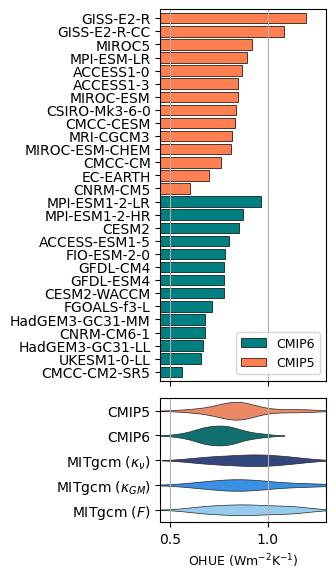

In [8]:
fnt = 9

models_cmip6_sorted = list(models_cmip6.sortby(OHUE_globe_cmip6).values)
models_cmip5_sorted = list(models_cmip5.sortby(OHUE_globe_cmip5).values)

OHUE_cmip6_sorted = list(OHUE_globe_cmip6.sortby(OHUE_globe_cmip6).values)
OHUE_cmip5_sorted = list(OHUE_globe_cmip5.sortby(OHUE_globe_cmip5).values)


import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(3.3, 5.68
                         ),constrained_layout=True)
gs =  fig.add_gridspec(4, 1, wspace=0.05,hspace=0.09)
ax1 = plt.subplot(gs[0:3, 0])
ax2 = plt.subplot(gs[3:4,0])
ax1.tick_params(labelbottom=False)

color = 'black'
ax1.barh(models_cmip6_sorted, OHUE_cmip6_sorted, color='teal', edgecolor='k',linewidth=.5)
ax1.barh(models_cmip5_sorted, OHUE_cmip5_sorted, color='coral', edgecolor='k',linewidth=.5)
ax1.tick_params(axis='x', labelcolor=color)
ax1.xaxis.grid()
ax1.tick_params(labelbottom=False)
ax1.set_xlim([.45,1.3])
ax1.margins(y=.01)
ax1.legend(['CMIP6','CMIP5'],loc=4,fontsize=9)


colors = ['#FF7F50',"#008080","#27408B",'#1E90FF', "#87CEFA"]
customPalette = sns.set_palette(sns.color_palette(colors))


sns.violinplot(data=full, x="ohue",y="exp",linewidth=.5,ax=ax2,inner=None)
ax2.set_xlim([.45,1.3])
ax2.set_yticklabels(['CMIP5','CMIP6',r'MITgcm ($\kappa_{\nu}$)','MITgcm ($\kappa_{GM}$)','MITgcm ($F$)'])
ax2.xaxis.grid()
ax2.tick_params(axis='x', labelcolor=color)
ax2.set_xlabel('OHUE (Wm$^{-2}$K$^{-1}$)', color=color,fontsize=9)
ax2.set_ylabel('', color=color,fontsize=9)
plt.savefig('OHUE_global_all.pdf',)

#### Open and define zonal-mean interior fields (N2, density, and slope)

In [20]:
strat_cmip5 = xr.open_dataarray('N2_cmip5.nc')
strat_cmip6 = xr.open_dataarray('N2_cmip6.nc')

density_cmip5 = xr.open_dataarray('density_cmip5.nc')
density_cmip6 = xr.open_dataarray('density_cmip6.nc')

slope_cmip5 = xr.open_dataarray('slope_cmip5.nc').rename('isopycnal_slope')
slope_cmip6 = xr.open_dataarray('slope_cmip6.nc').rename('isopycnal_slope')

strat = xr.concat([strat_cmip5,strat_cmip6],dim='model')
density = xr.concat([density_cmip5,density_cmip6],dim='model')
slope = xr.concat([slope_cmip5, slope_cmip6],dim='model')

#### Plot zonal-mean density

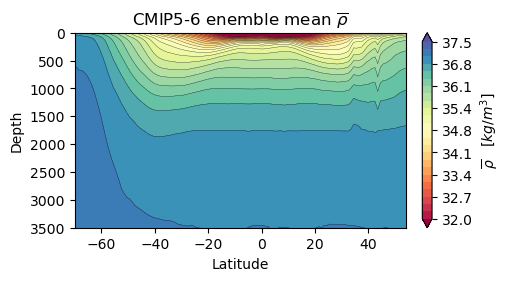

In [13]:
import matplotlib.ticker as tick
fig = plt.figure(figsize =(5, 2.7),constrained_layout=True)
cont=(density).mean('model').plot.contourf(levels=25,vmax=37.5,vmin=32,cmap='Spectral',add_colorbar=False)
(density).mean('model').plot.contour(levels=25,vmax=37.5,vmin=32,colors='k',linewidths=.2)
#rho_norm.mean('model').plot.contour(levels=[1/np.exp(1)],colors='k',linewidths=2)
cbar = plt.colorbar(cont)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.set_label(r'$\overline{\rho} \quad [kg/m^{3}]$')
plt.ylim(3500,0)
plt.title(r'CMIP5-6 enemble mean $\overline{\rho}$')
plt.ylabel('Depth')
plt.xlabel('Latitude')
plt.xlim(-70,54)
plt.savefig('Density.pdf')


####  Calculate $\overline{\rho_{norm}}$ in y, z space

In [21]:
lat = -45  
ml_depth = 350

rho_norm = -(density -density.max('lev'))
rho_norm = rho_norm.where(rho_norm<rho_norm.sel(lev=ml_depth,method='nearest').sel(y=lat,method='nearest'))
rho_norm = rho_norm/rho_norm.max('lev')
rho_norm= rho_norm.rename('rho_norm')

#### Plot $\overline{\rho_{norm}}$ in y, z space

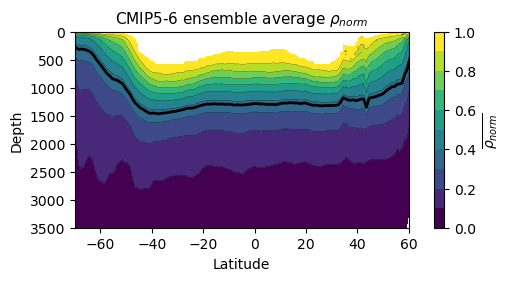

In [22]:
fig = plt.figure(figsize =(5, 2.7),constrained_layout=True)
cont=rho_norm.mean('model').plot.contourf(levels=11,vmax=1,add_colorbar=False)
rho_norm.mean('model').plot.contour(levels=11,vmax=1,linewidths=.2,colors='k',add_colorbar=False)

rho_norm.mean('model').plot.contour(levels=[1/np.exp(1)],colors='k',linewidths=2)
plt.ylim(3500,0)
cbar = plt.colorbar(cont)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.set_label(r'$\overline{\rho_{norm}}$')

plt.title(r'CMIP5-6 ensemble average $\rho_{norm}$',fontsize = 11)
plt.ylabel('Depth')
plt.xlabel('Latitude')
plt.xlim(-70,60)
plt.savefig('Pyc_metric.pdf')

#### Transform $\overline{\rho_{norm}}(y,z)$ into $z(y,\overline{\rho_{norm}})$ space, to find depth of pycnocline metric

In [23]:
Y=rho_norm.y.values
lev=rho_norm.lev.values
file_lev_bounds = '/gws/nopw/j04/ukfafmip/users/enewsom/regrid_from_jonathan_thetoa/cmip6/CONCATTED/thetao_Oyr_CESM2_piControl_r1i1p1f1_gn_regridded_050001-059912.nc'
dh  = xr.open_dataset(file_lev_bounds).assign_attrs(source_id='CESM2')
dh=combined_preprocessing(dh)
lev_bounds=dh.lev_bounds.isel(bnds=1).values

ds = xr.Dataset(
     coords={
         "y_c": (
             ["y_c"],
             Y,
                   ),
         "y_g": (
             ["y_g"],
             Y+.5, ),
     "lev": (
             ["lev"],
             lev,
         ),
         "lev_g": (
             ["lev_g"],
             lev_bounds)})
grid = Grid(ds, coords={"Y": {"center": "y_c", "right": "y_g"},"lev": {"center": "lev", "right": "lev_g"}},periodic=False)
lev_grid = rho_norm.lev.broadcast_like(rho_norm)
target_levels = np.arange(0,1,.025)
depth_rho_norm = grid.transform(lev_grid, 'lev', target_levels, target_data=rho_norm, method='linear')


/home/users/enewsom/.conda/envs/nbenv2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


#### Calculate metrics in SO region and combine into one dataset

In [24]:
pyc_level=1/np.exp(1) #defines pycnocline as rho_norm=1/e
lats = slice(-60,60) #latitudes to average the pycnocline

lev_slice = slice(450,900) #depths in SO to average
lat_slice = slice(-57,-47)  #lats in SO to average

#the following defines a grid of dz values for averaging
dz = xr.zeros_like(strat.isel(model=0))
dz0 = np.gradient(strat.lev.broadcast_like(strat.isel(model=0)))[0]
dz.values = dz0
dz_m = dz.sel(lev=lev_slice,y=lat_slice).sum(['lev','y'])

#average metrics and combine
d = depth_rho_norm.sel(rho_norm=pyc_level,method='nearest').sel(y=lats).mean('y')
n = (strat*dz).sel(lev=lev_slice,y=lat_slice).sum(['lev','y'])*1e5/dz_m
s = (slope*dz).sel(lev=lev_slice,y=lat_slice).sum(['lev','y'])*1e3/dz_m
df = xr.merge([OHUE.dropna('model').rename('ohue'),d.rename('depth'),n.rename('N2'),s.rename('slope')])
ds_mit_full = xr.concat([ds_mit_f,ds_mit_gm,ds_mit_kv],dim='model')


### Plot metrics (global and OHUE$_{midlats}$)

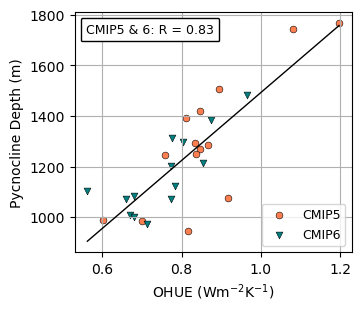

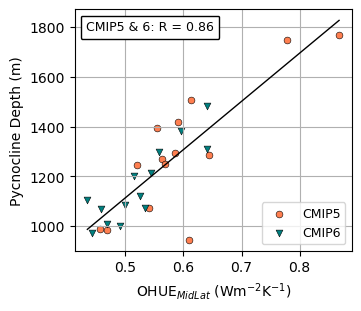

In [26]:
ohue_labels = ['OHUE','OHUE$_{MidLat}$','OHUE$_{NHighLat}$','OHUE$_{SHighLat}$','OHUE$_{LowLat}$']
metric_labels=['Pycnocline Depth (m)','$\overline{N^2}$ ($10^{-5}s^{-2}$)','Isopycnal slopes ($10^{-3}$)']
reg_abrv = ['global','midlats','NH','SH','LL']
marksize= 24
fnt=9
metrics = ['depth']#,'N2','slope']

for surf in range(0,2): #increase range to plot remaining regions
    for j, metric in enumerate(metrics):

        #fig, ax = plt.subplots(1,figsize =(3.2,2.8),constrained_layout=True)
        fig, ax = plt.subplots(1,figsize =(3.5,3),constrained_layout=True)
        
        reg = reg_abrv[surf]    
        data5 = df.isel(surf_reg=surf).sel(model=models_cmip5) 
        data6 = df.isel(surf_reg=surf).sel(model=models_cmip6)
        data_full = df.isel(surf_reg=surf)
        
        sns.scatterplot(data=data5, x="ohue", y=metric, edgecolor='k',  color="coral",s=marksize, marker='o')
        sns.scatterplot(data=data6, x="ohue", y=metric,edgecolor='k',  color="teal",s=marksize, marker='v')
        sns.regplot(x='ohue', y=metric, data=data_full, fit_reg=True,ci=0, ax=ax,scatter=False, color="k",line_kws={"lw":1})
        
        p = xs.pearson_r_p_value(data_full[metric],data_full.ohue,dim='model',skipna=True )
        r = xr.corr(data_full[metric],data_full.ohue)

        if r.values <0:
            loc1 = 3
            loc2 =1
        else:
            loc1 = 4
            loc2 = 2
        plt.legend(['CMIP5','CMIP6'],fontsize=fnt,loc=loc1)
        #plt.ylim(850,2100)
        at = textonly(plt.gca(), 'CMIP5 & 6: R = '+str(np.round(r.values,2)),fontsize=fnt,loc=loc2) 

        plt.ylabel(metric_labels[j])
        plt.xlabel(ohue_labels[surf]+' (Wm$^{-2}$K$^{-1}$)') 
        plt.grid()
        
        plt.savefig('OHUE_metrics_plot_'+metric+'_'+reg+'.pdf')

### Plot MIT metrics

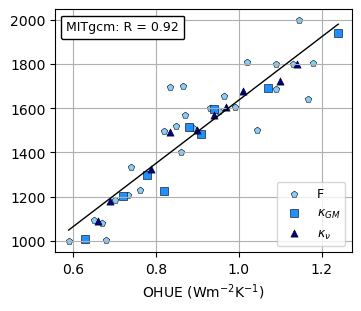

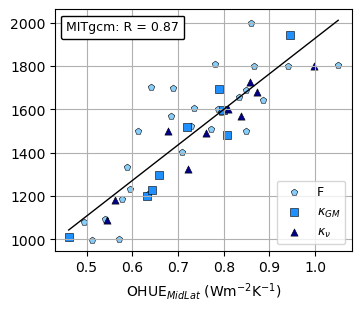

In [27]:

metrics = ['depth']#,'N2','slope']

for surf in range(0,2): #increase range to plot remaining regions
    for j, metric in enumerate(metrics):
        fig, ax = plt.subplots(1,figsize =(3.5,3),constrained_layout=True)

        reg = reg_abrv[surf]    
        data_f = ds_mit_f.isel(surf_reg=surf)
        data_gm = ds_mit_gm.isel(surf_reg=surf)
        data_kv = ds_mit_kv.isel(surf_reg=surf)
        data_full = ds_mit_full.isel(surf_reg=surf)
        
        sns.scatterplot(data=data_f, x="ohue", y=metric,edgecolor='k',  color="lightskyblue",s=marksize, marker='p')
        sns.scatterplot(data=data_gm, x="ohue", y=metric,edgecolor='k',  color="dodgerblue",s=marksize+2, marker='s')
        sns.scatterplot(data=data_kv, x="ohue", y=metric,edgecolor='k',  color="darkblue",s=marksize+3, marker='^')
        sns.regplot(x='ohue', y=metric, data=data_full, fit_reg=True,ci=0, ax=ax,scatter=False, color="k",line_kws={"lw":1})    
        p = xs.pearson_r_p_value(data_full[metric],data_full.ohue,dim='model',skipna=True )
        r = xr.corr(data_full[metric],data_full.ohue)
        if r.values <0:
            loc1 = 3
            loc2 =1
        else:
            loc1 = 4
            loc2 = 2
        plt.legend([r'F','$\kappa_{GM}$',r'$\kappa_{\nu}$'],fontsize=fnt,loc=loc1)
        at = textonly(plt.gca(), 'MITgcm: R = '+str(np.round(r.values,2)),fontsize=fnt,loc=loc2) 
        plt.ylabel(metric_labels[j])
        plt.ylabel('')
        plt.xlabel(ohue_labels[surf]+' (Wm$^{-2}$K$^{-1}$)') 
        plt.grid()
        plt.savefig('OHUE_metrics_plot_'+metric+'_MIT_'+reg+'.pdf')

In [28]:
strat_corr ,pp,m = corr_model(strat,OHUE.isel(surf_reg = np.array([0,1])))

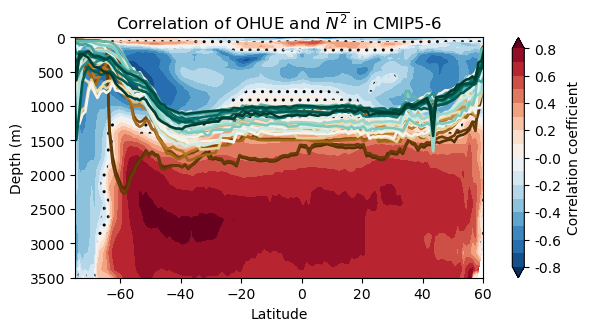

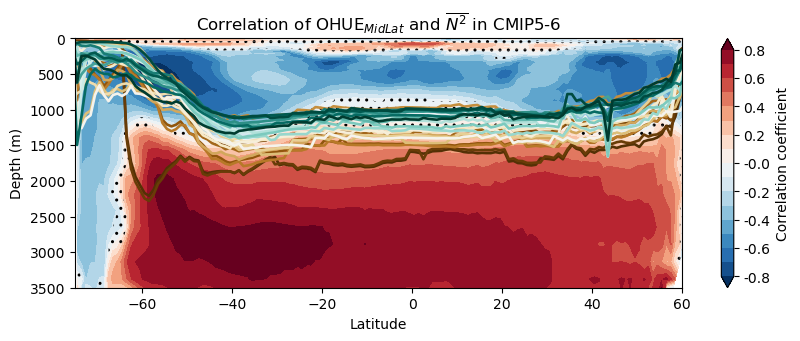

In [29]:
string1 = 'OHUE$_{MidLat}$'
falloff=1/np.exp(1)
surfs = np.array([0,1,2,3,4,5])

for surf in np.arange(0,2):
    


    if surf ==0:
        string1 = 'OHUE'
        fig = plt.figure(figsize =(5.8, 3.2),constrained_layout=True)
    if surf ==1:
        string1 = 'OHUE$_{MidLat}$'
        fig = plt.figure(figsize =(7.9, 3.3),constrained_layout=True)
    if surf ==2:
        string1 = 'OHUE$_{NHighLat}$'
        fig = plt.figure(figsize =(5.8, 3.2),constrained_layout=True)
    if surf ==3:
        string1 = 'OHUE$_{SHighLat}$'
        fig = plt.figure(figsize =(5.8, 3.2),constrained_layout=True)
    if surf ==5:
        string1 = 'OHUE$_{LowLat}$'
        fig = plt.figure(figsize =(5.8, 3.2),constrained_layout=True)

    ax = fig. add_subplot()
    pyc = depth_rho_norm.sel(rho_norm=.4,method='nearest')
    var1 = OHUE.isel(surf_reg=surf)
    color=iter(cm.BrBG(np.linspace(0,1,len(pyc.model))))
    
    var = strat_corr.isel(surf_reg=surf)
    p = pp.isel(surf_reg=surf)
    if surf == 0:
        pg = p
    if surf == 1:
        pml = p
    plot=var.plot.contourf(levels=np.arange(-.8,.9,.1),
                      cmap='RdBu_r',
                           add_colorbar=False)
    plot_h=var.where(p>.3).plot.contourf(levels=15,vmax=1,colors='none',
                      hatches=['..'],add_colorbar=False)
    plt.ylim(3500,0)
    cbar = fig.colorbar(plot)
    cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
    for pathcoll in plot_h.collections:
        pathcoll.set_rasterized(True)
    for pathcoll in plot.collections:
        pathcoll.set_rasterized(True)
    for i,j in enumerate(pyc.model.sortby(var1,ascending=False)):
        c=next(color)
        l = pyc.sel(model=j).plot(x='y',color = c,linewidth=1.9)
    #plt.legend(loc=0)
    #l = pyc.mean('model').plot(x='y',color = 'k',linewidth=3)
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude')
    plt.title('Correlation of '+string1+' and $\overline{N^2}$ in CMIP5-6')
    plt.xlim(-75,60)
    cbar.set_label('Correlation coefficient')
    
    plt.savefig('OHUE_N2_plot_'+string1+'.pdf',bbox_inches='tight',dpi=150)

## Test sensitivity to other pycnocline metrics

#### Depth of isopycnal: Transform $\overline{\rho}(y,z)$ into $z(y,\overline{\rho})$ space, to find depth of pycnocline metric

In [30]:
target_levels = np.arange(30,37.8,.2)
depth_rho = grid.transform(lev_grid, 'lev', target_levels, target_data=density, method='linear')

/home/users/enewsom/.conda/envs/nbenv2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


#### Gnandesikan 1999 metric: solve for $z_\sigma =\int_{z=-H}^0 \Delta \sigma_2 z dz/ \int_{z=-H}^0 \Delta\sigma_2 dz$

In [33]:
z = delta_sig.lev.broadcast_like(delta_sig)
dz = z.differentiate('lev')
dz_sig = (delta_sig*z*dz).sum('lev')
dsig = (delta_sig*dz).sum('lev')
z_s = dz_sig/dsig

#### Combine to plot

In [37]:
d_dens = depth_rho.sel(density=36.6,method='nearest').sel(y=lats).mean('y')
d_gnan = z_s.sel(y=lats).mean('y')

n = (strat*dz).sel(lev=lev_slice,y=lat_slice).sum(['lev','y'])*1e5/dz_m
s = (slope*dz).sel(lev=lev_slice,y=lat_slice).sum(['lev','y'])*1e3/dz_m
df = xr.merge([OHUE.dropna('model').rename('ohue'),d.rename('depth_exp'),d_dens.rename('depth_iso'),d_gnan.rename('depth_gnan'),n.rename('N2'),s.rename('slope')])


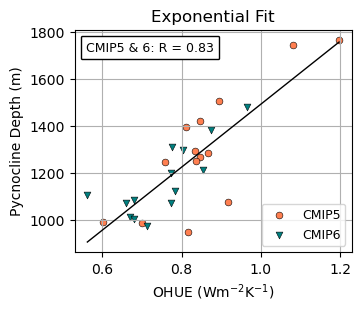

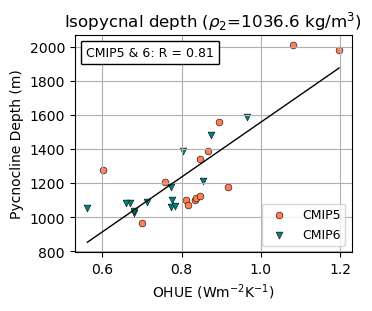

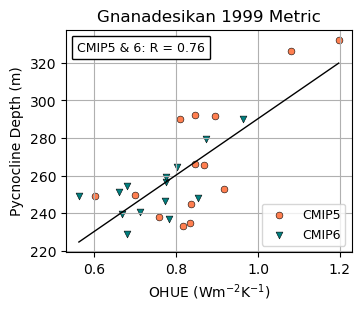

In [38]:
title = ['Exponential Fit',r'Isopycnal depth ($\rho_2$=1036.6 kg/m$^3$)','Gnanadesikan 1999 Metric']

metrics = ['depth_exp','depth_iso','depth_gnan']

for surf in range(0,1): #increase range to plot remaining regions
    for j, metric in enumerate(metrics):

        fig, ax = plt.subplots(1,figsize =(3.5,3),constrained_layout=True)
        plt.title(title[j])
        reg = reg_abrv[surf]    
        data5 = df.isel(surf_reg=surf).sel(model=models_cmip5) 
        data6 = df.isel(surf_reg=surf).sel(model=models_cmip6)
        data_full = df.isel(surf_reg=surf)
        
        sns.scatterplot(data=data5, x="ohue", y=metric, edgecolor='k',  color="coral",s=marksize, marker='o')
        sns.scatterplot(data=data6, x="ohue", y=metric,edgecolor='k',  color="teal",s=marksize, marker='v')
        sns.regplot(x='ohue', y=metric, data=data_full, fit_reg=True,ci=0, ax=ax,scatter=False, color="k",line_kws={"lw":1})
        
        p = xs.pearson_r_p_value(data_full[metric],data_full.ohue,dim='model',skipna=True )
        r = xr.corr(data_full[metric],data_full.ohue)

        if r.values <0:
            loc1 = 3
            loc2 =1
        else:
            loc1 = 4
            loc2 = 2
        plt.legend(['CMIP5','CMIP6'],fontsize=9,loc=loc1)
        #plt.ylim(850,2100)
        at = textonly(plt.gca(), 'CMIP5 & 6: R = '+str(np.round(r.values,2)),fontsize=9,loc=loc2) 
        plt.ylabel(metric_labels[0])
        plt.xlabel(ohue_labels[surf]+' (Wm$^{-2}$K$^{-1}$)') 
        plt.grid()
        plt.savefig('OHUE_metrics_plot_'+metric+'_'+reg+'.pdf')